In [16]:
import matplotlib.pyplot as plt
import numpy as np
import mplhep as hep
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks
from iminuit import Minuit
from iminuit.cost import LeastSquares
import pickle

In [17]:
with open('../../genIII_data/JLab/Cosmic/Run1_list.txt') as f:
    lines = f.read().split('\n')
tags = None
IDs=[]
layers=[]
channels =[]
din={}
for line in lines:
    if line[:2]=="//" or len(line)==0:
        continue

    if tags is None:
        tags = line.split()
        tags=tags[-3:]
        continue;

    split = line.split()
    layer, channel, LG, HG = split[0:4]

    ID=int(layer)*64+int(channel)

    if ID not in IDs:
        din[f"{ID}_LG"] = []
        din[f"{ID}_HG"] = []
        IDs.append(ID)
    din[f"{ID}_LG"].append(float(LG))
    din[f"{ID}_HG"].append(float(HG))
    
    
with open('../../genIII_data/JLab/Cosmic/CosmicPed.pkl', 'rb') as file:
    # Load the data from the pickle file
    ped = pickle.load(file)
    
HGPedMean = ped['HGPedMean']

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-b3e7b4280337>", line 2, in <module>
    lines = f.read().split('\n')
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Users/spreins/op


KeyboardInterrupt



In [3]:
with open('../../genIII_data/JLab/Cosmic/Run2_list.txt') as f:
    lines = f.read().split('\n')
tags = None

for line in lines:
    if line[:2]=="//" or len(line)==0:
        continue

    if tags is None:
        tags = line.split()
        tags=tags[-3:]
        continue;

    split = line.split()
    layer, channel, LG, HG = split[0:4]

    ID=int(layer)*64+int(channel)

    if ID not in IDs:
        din[f"{ID}_LG"] = []
        din[f"{ID}_HG"] = []
        IDs.append(ID)
    din[f"{ID}_LG"].append(float(LG))
    din[f"{ID}_HG"].append(float(HG))

In [4]:
print(len(din["0_LG"]))

122069


In [5]:
def configure_plotting():
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['savefig.facecolor'] = 'white'
    plt.rcParams['savefig.bbox'] = 'tight'
    hep.style.use(hep.style.CMS)

# Process a single channel and return the estimated MIP peak position
def process_channel(data, channel_key, ax):
    data = np.array(data[channel_key])
    counts, bin_edges = np.histogram(data, bins=20, range=[0, 8000])
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    errors = np.sqrt(counts)
    mask = counts < 2000
    bin_centers = bin_centers[mask]
    errors = errors[mask]
    counts = counts[mask]

    # Plot raw data
    ax.errorbar(bin_centers, counts, yerr=errors, fmt='o', label=channel_key)

    # Smooth histogram with spline
    spline = UnivariateSpline(bin_centers, counts, s=500, k=3)
    interp_x = np.linspace(bin_centers[0], bin_centers[-1], 8000)
    interp_y = spline(interp_x)

    # Find peaks and their heights
    peaks, properties = find_peaks(interp_y, height=0)
    peak_positions = interp_x[peaks]
    peak_heights = properties['peak_heights']


    valid_indices = [i for i, x in enumerate(peak_positions) if x > 2000]
    if valid_indices:
        # Find the index of the highest peak among the valid ones
        max_idx = valid_indices[np.argmax([peak_heights[i] for i in valid_indices])]
        mip_peak = peak_positions[max_idx]
    else:
        mip_peak = 0

    ax.axvline(x=mip_peak)
    ax.plot(interp_x, interp_y, linestyle="--")
    ax.set_yscale('log')
    ax.legend()
    ax.set_ylim(1, 10000)

    return mip_peak

# Analyze all channels for a given CAEN unit and return MIP values
def analyze_caen_unit(din, caen_unit, MIPs):
    num_channels = 64
    num_cols = 8
    num_rows = 8
    configure_plotting()
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 30), sharey=True, sharex=True)
    axes = axes.flatten()

    for i in range(num_channels):
        channel_key = f"{i + (64 * caen_unit)}_HG"
        mip = process_channel(din, channel_key, axes[i])
        MIPs.append(mip)

        if i % num_cols == 0:
            axes[i].set_ylabel('Count')
        if i >= (num_rows - 1) * num_cols:
            axes[i].set_xlabel('ADC')

    plt.tight_layout(pad=0.0)
    plt.tight_layout(rect=[0, 0, 1.5, 1])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

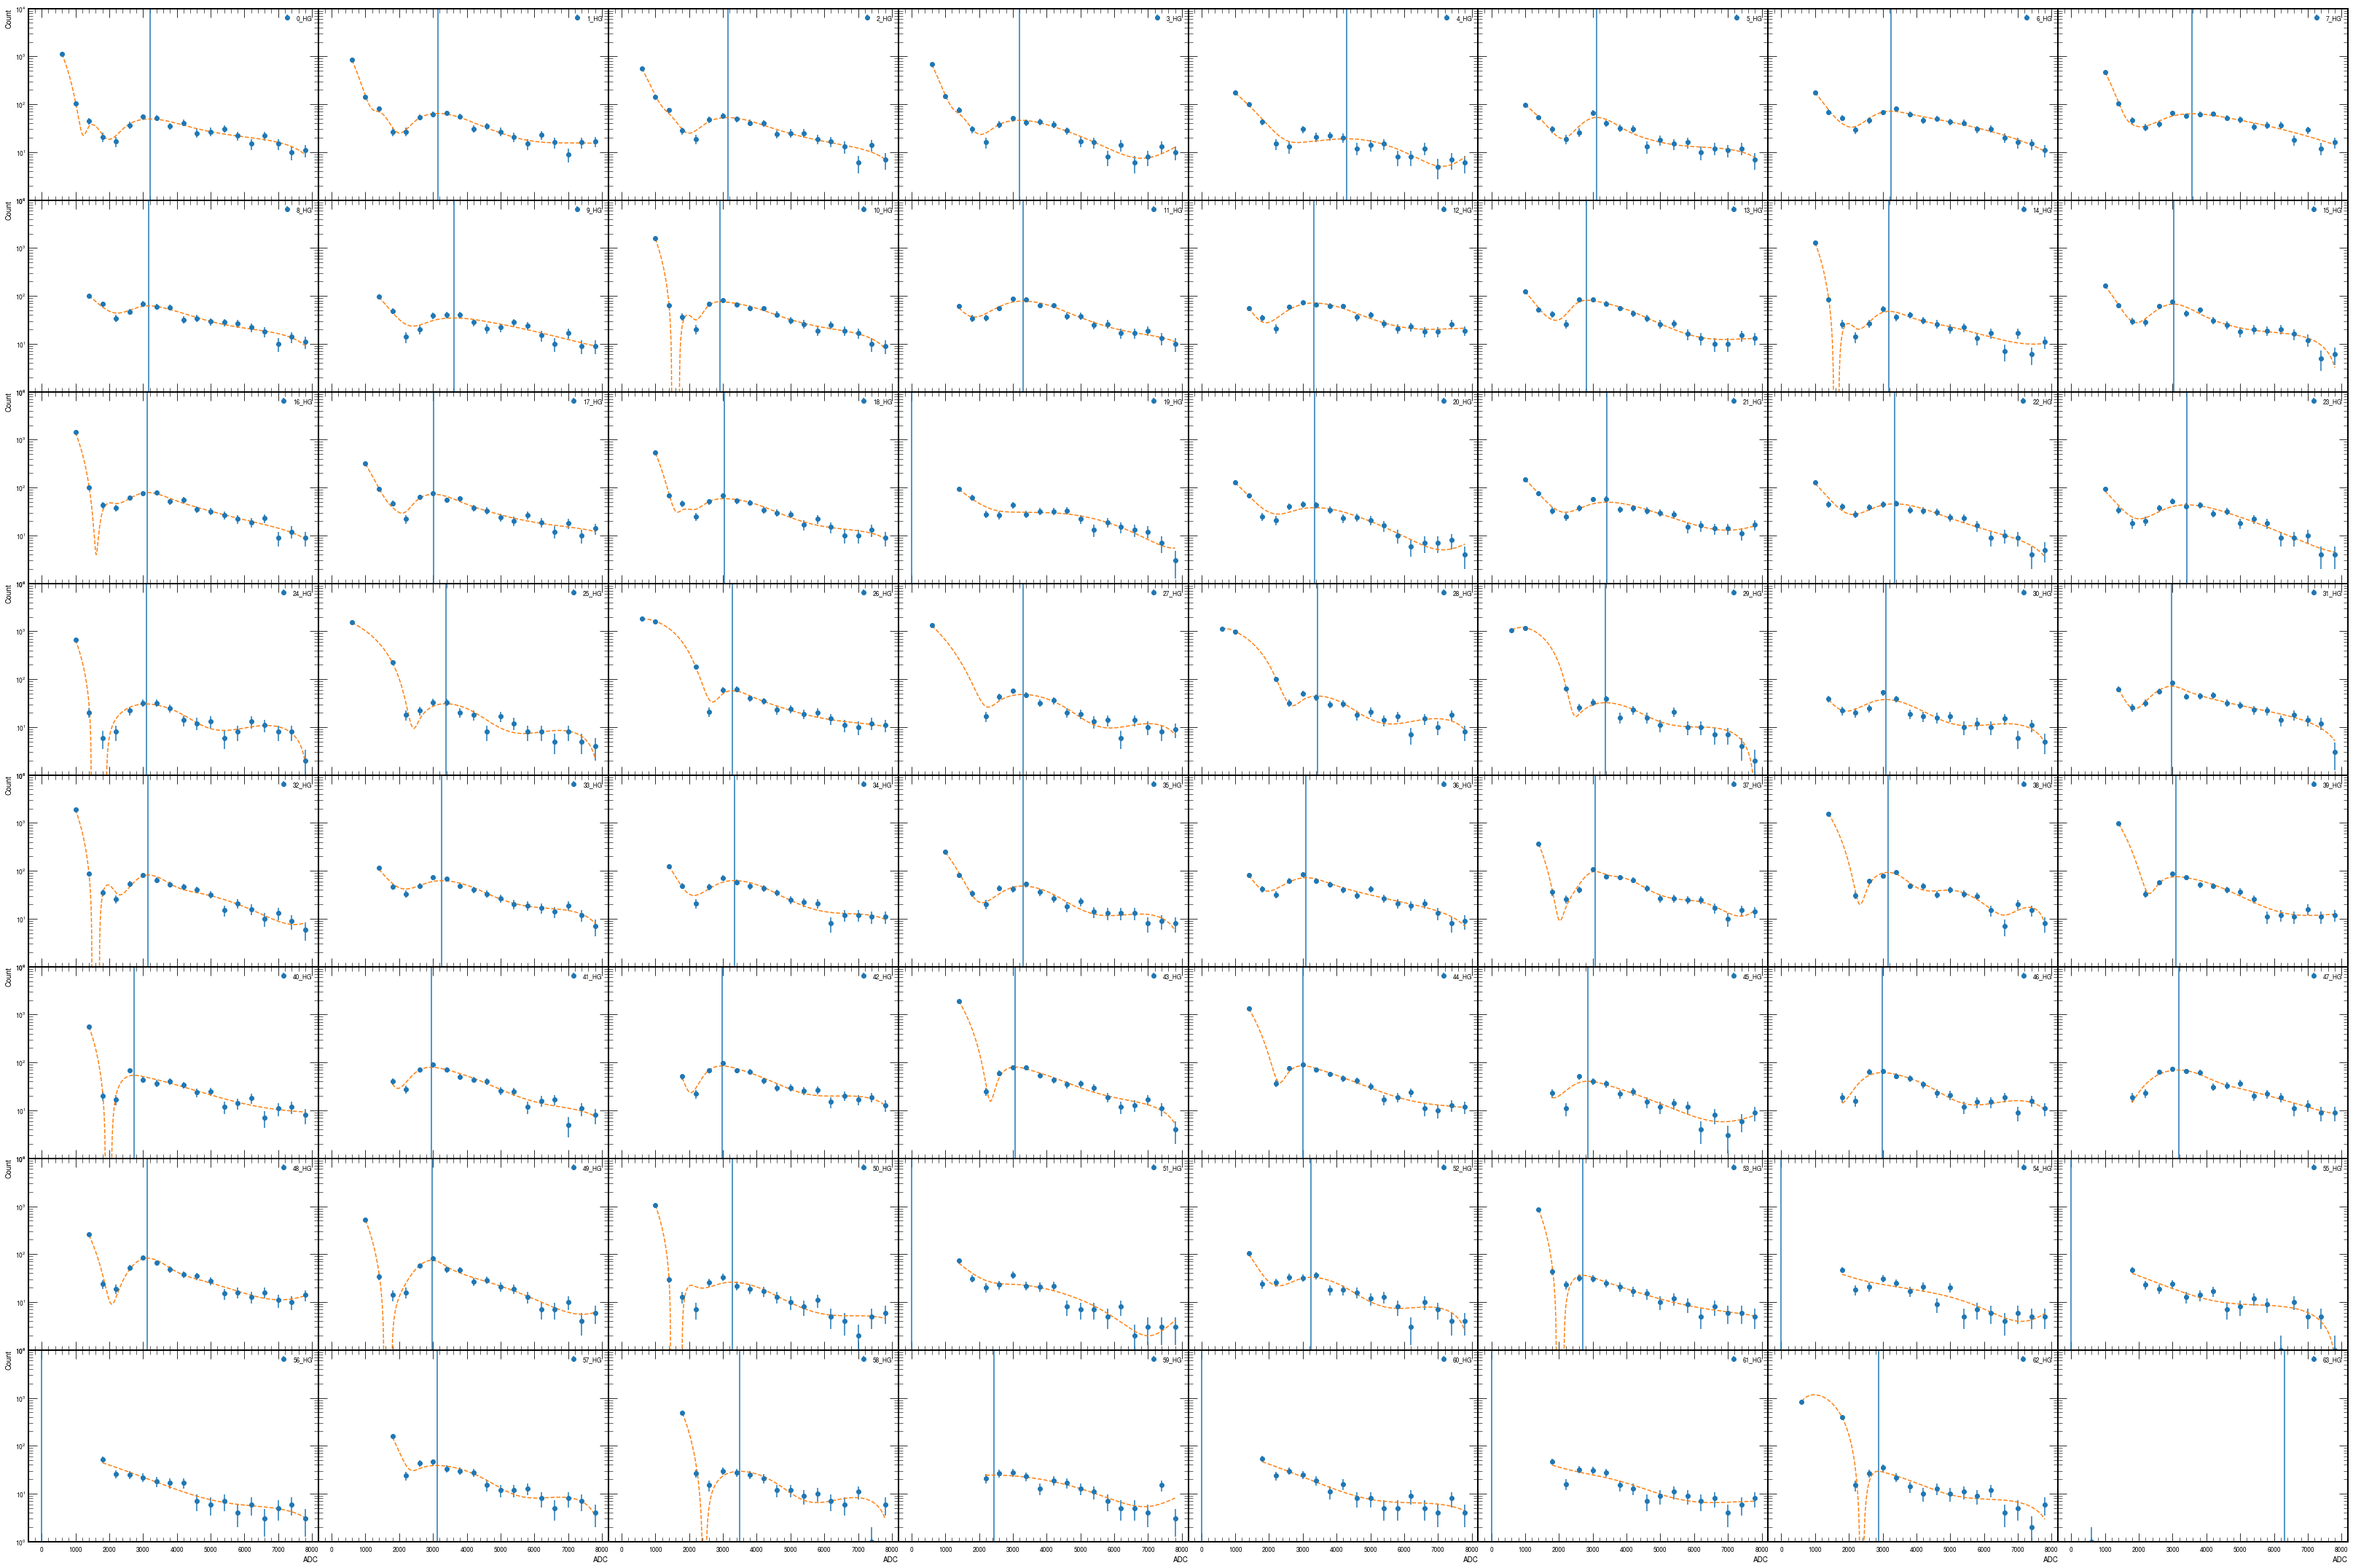

/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


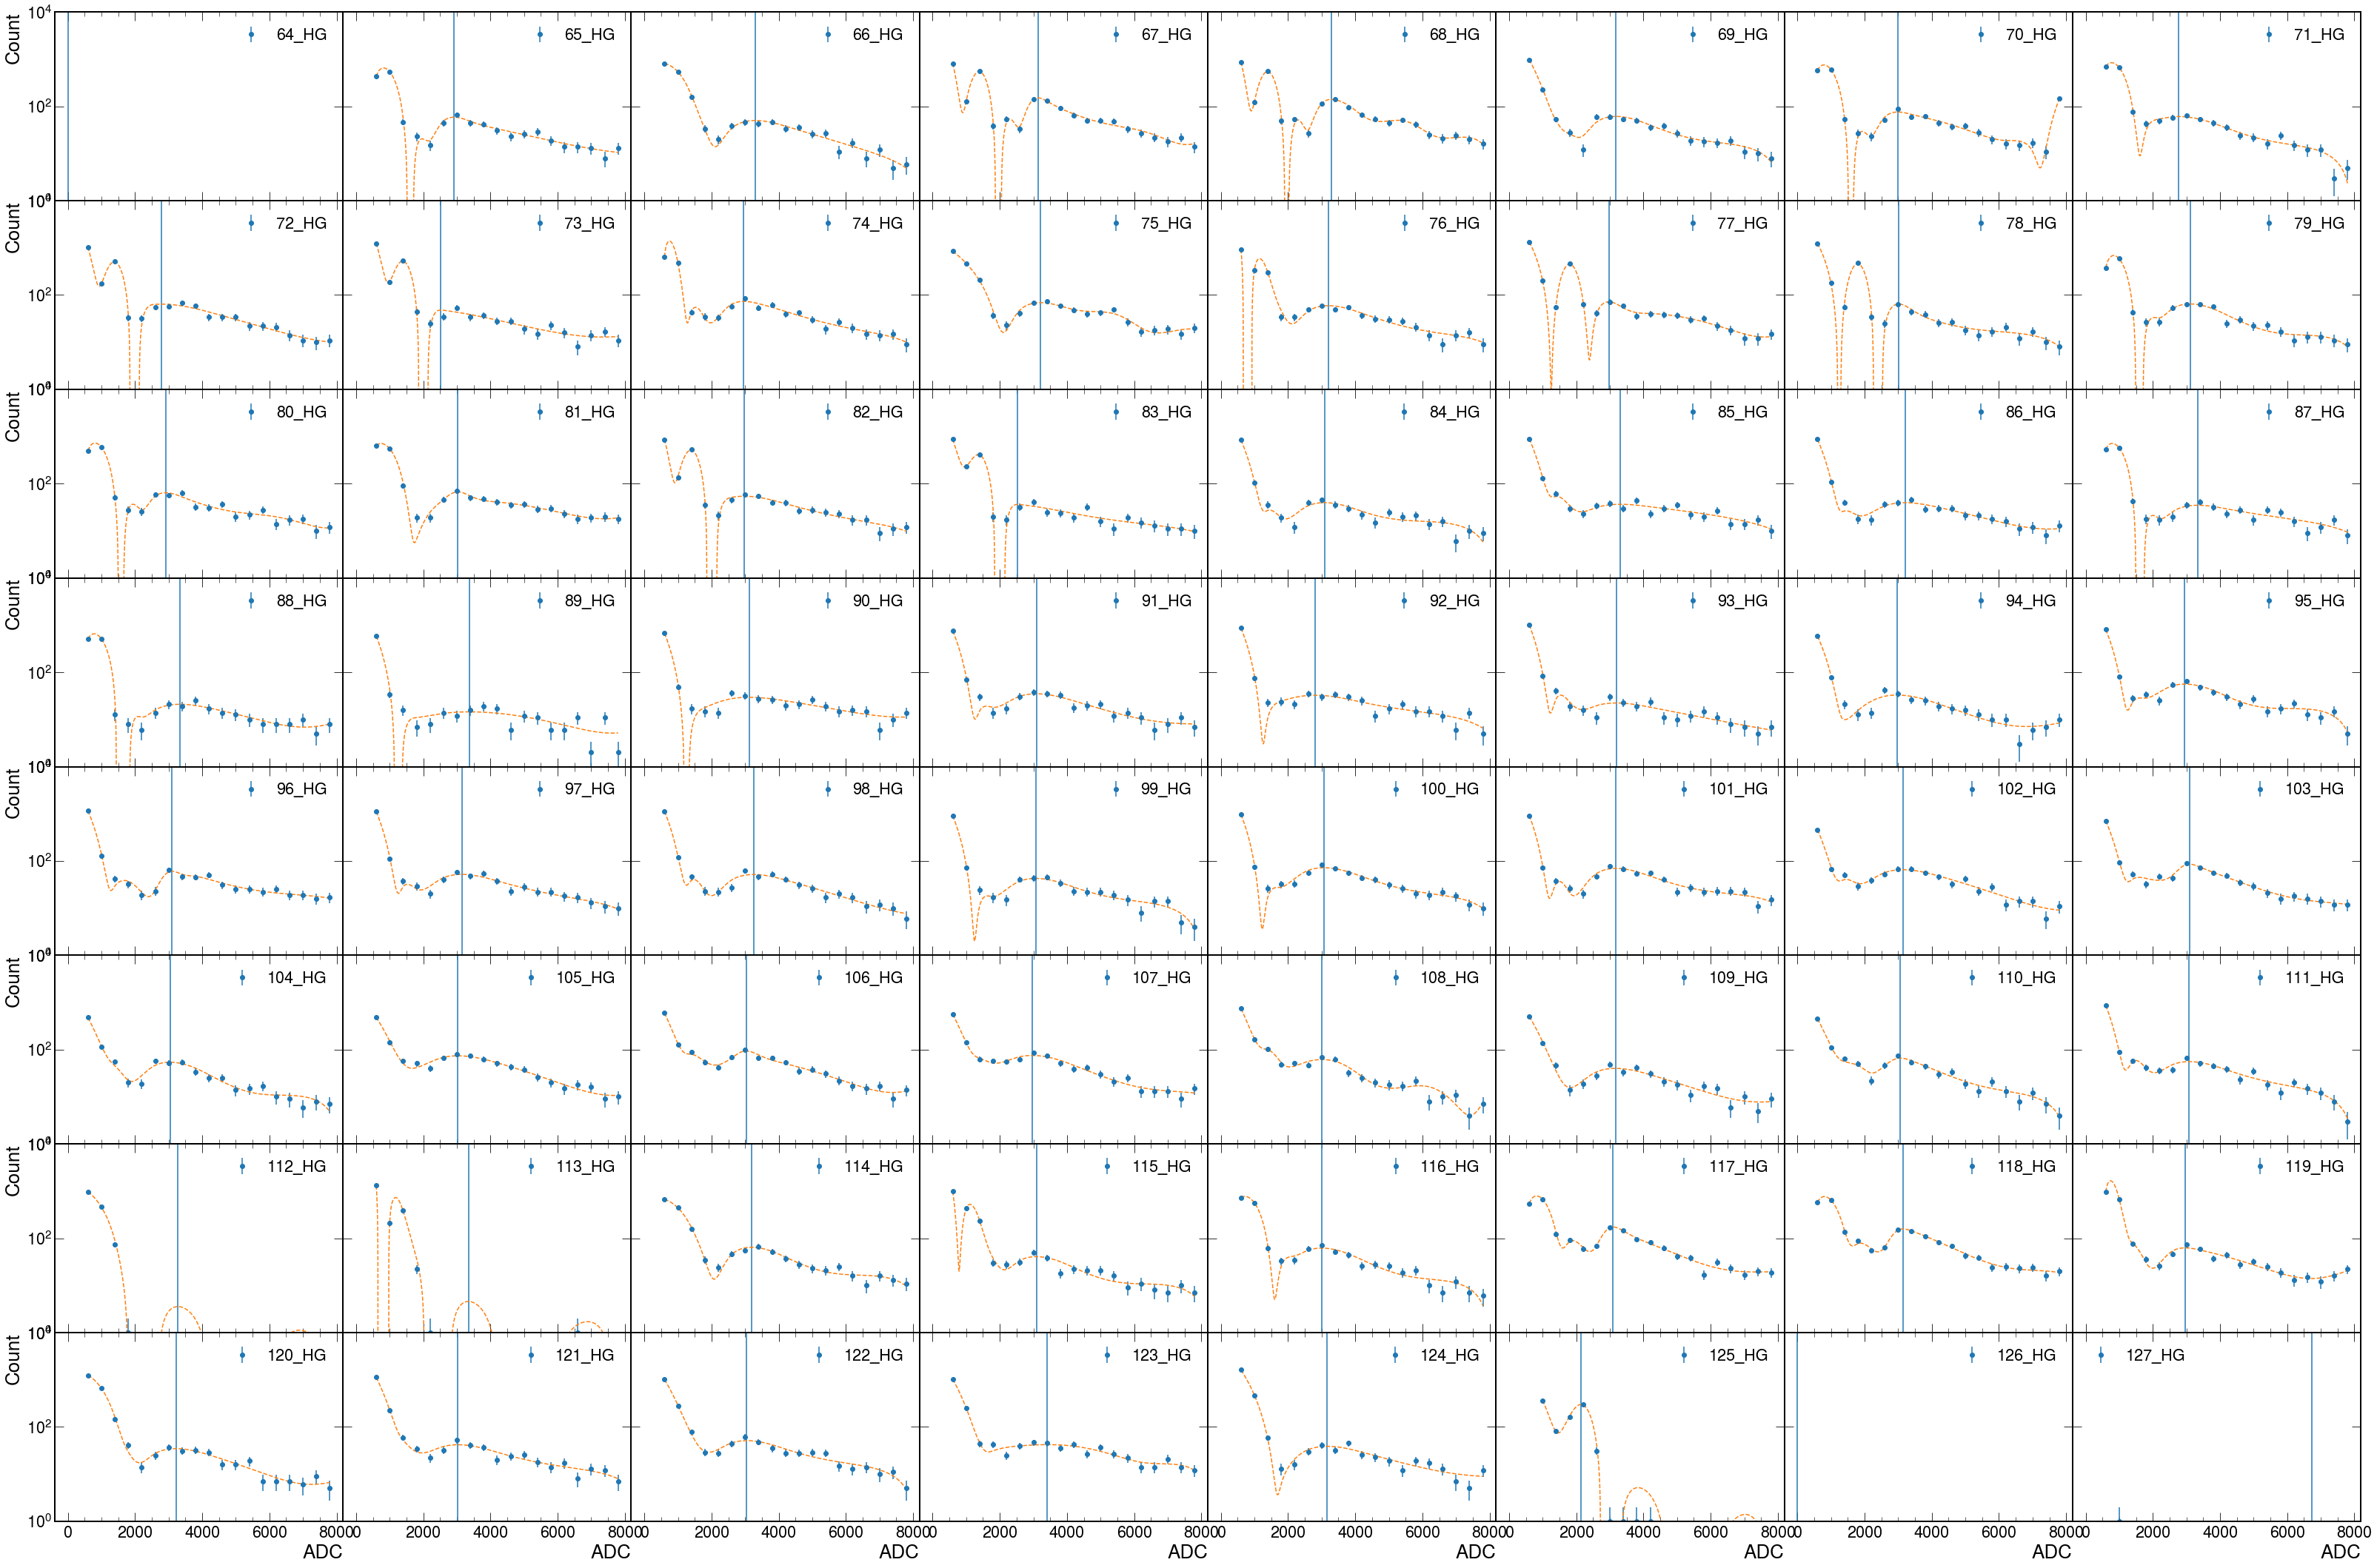

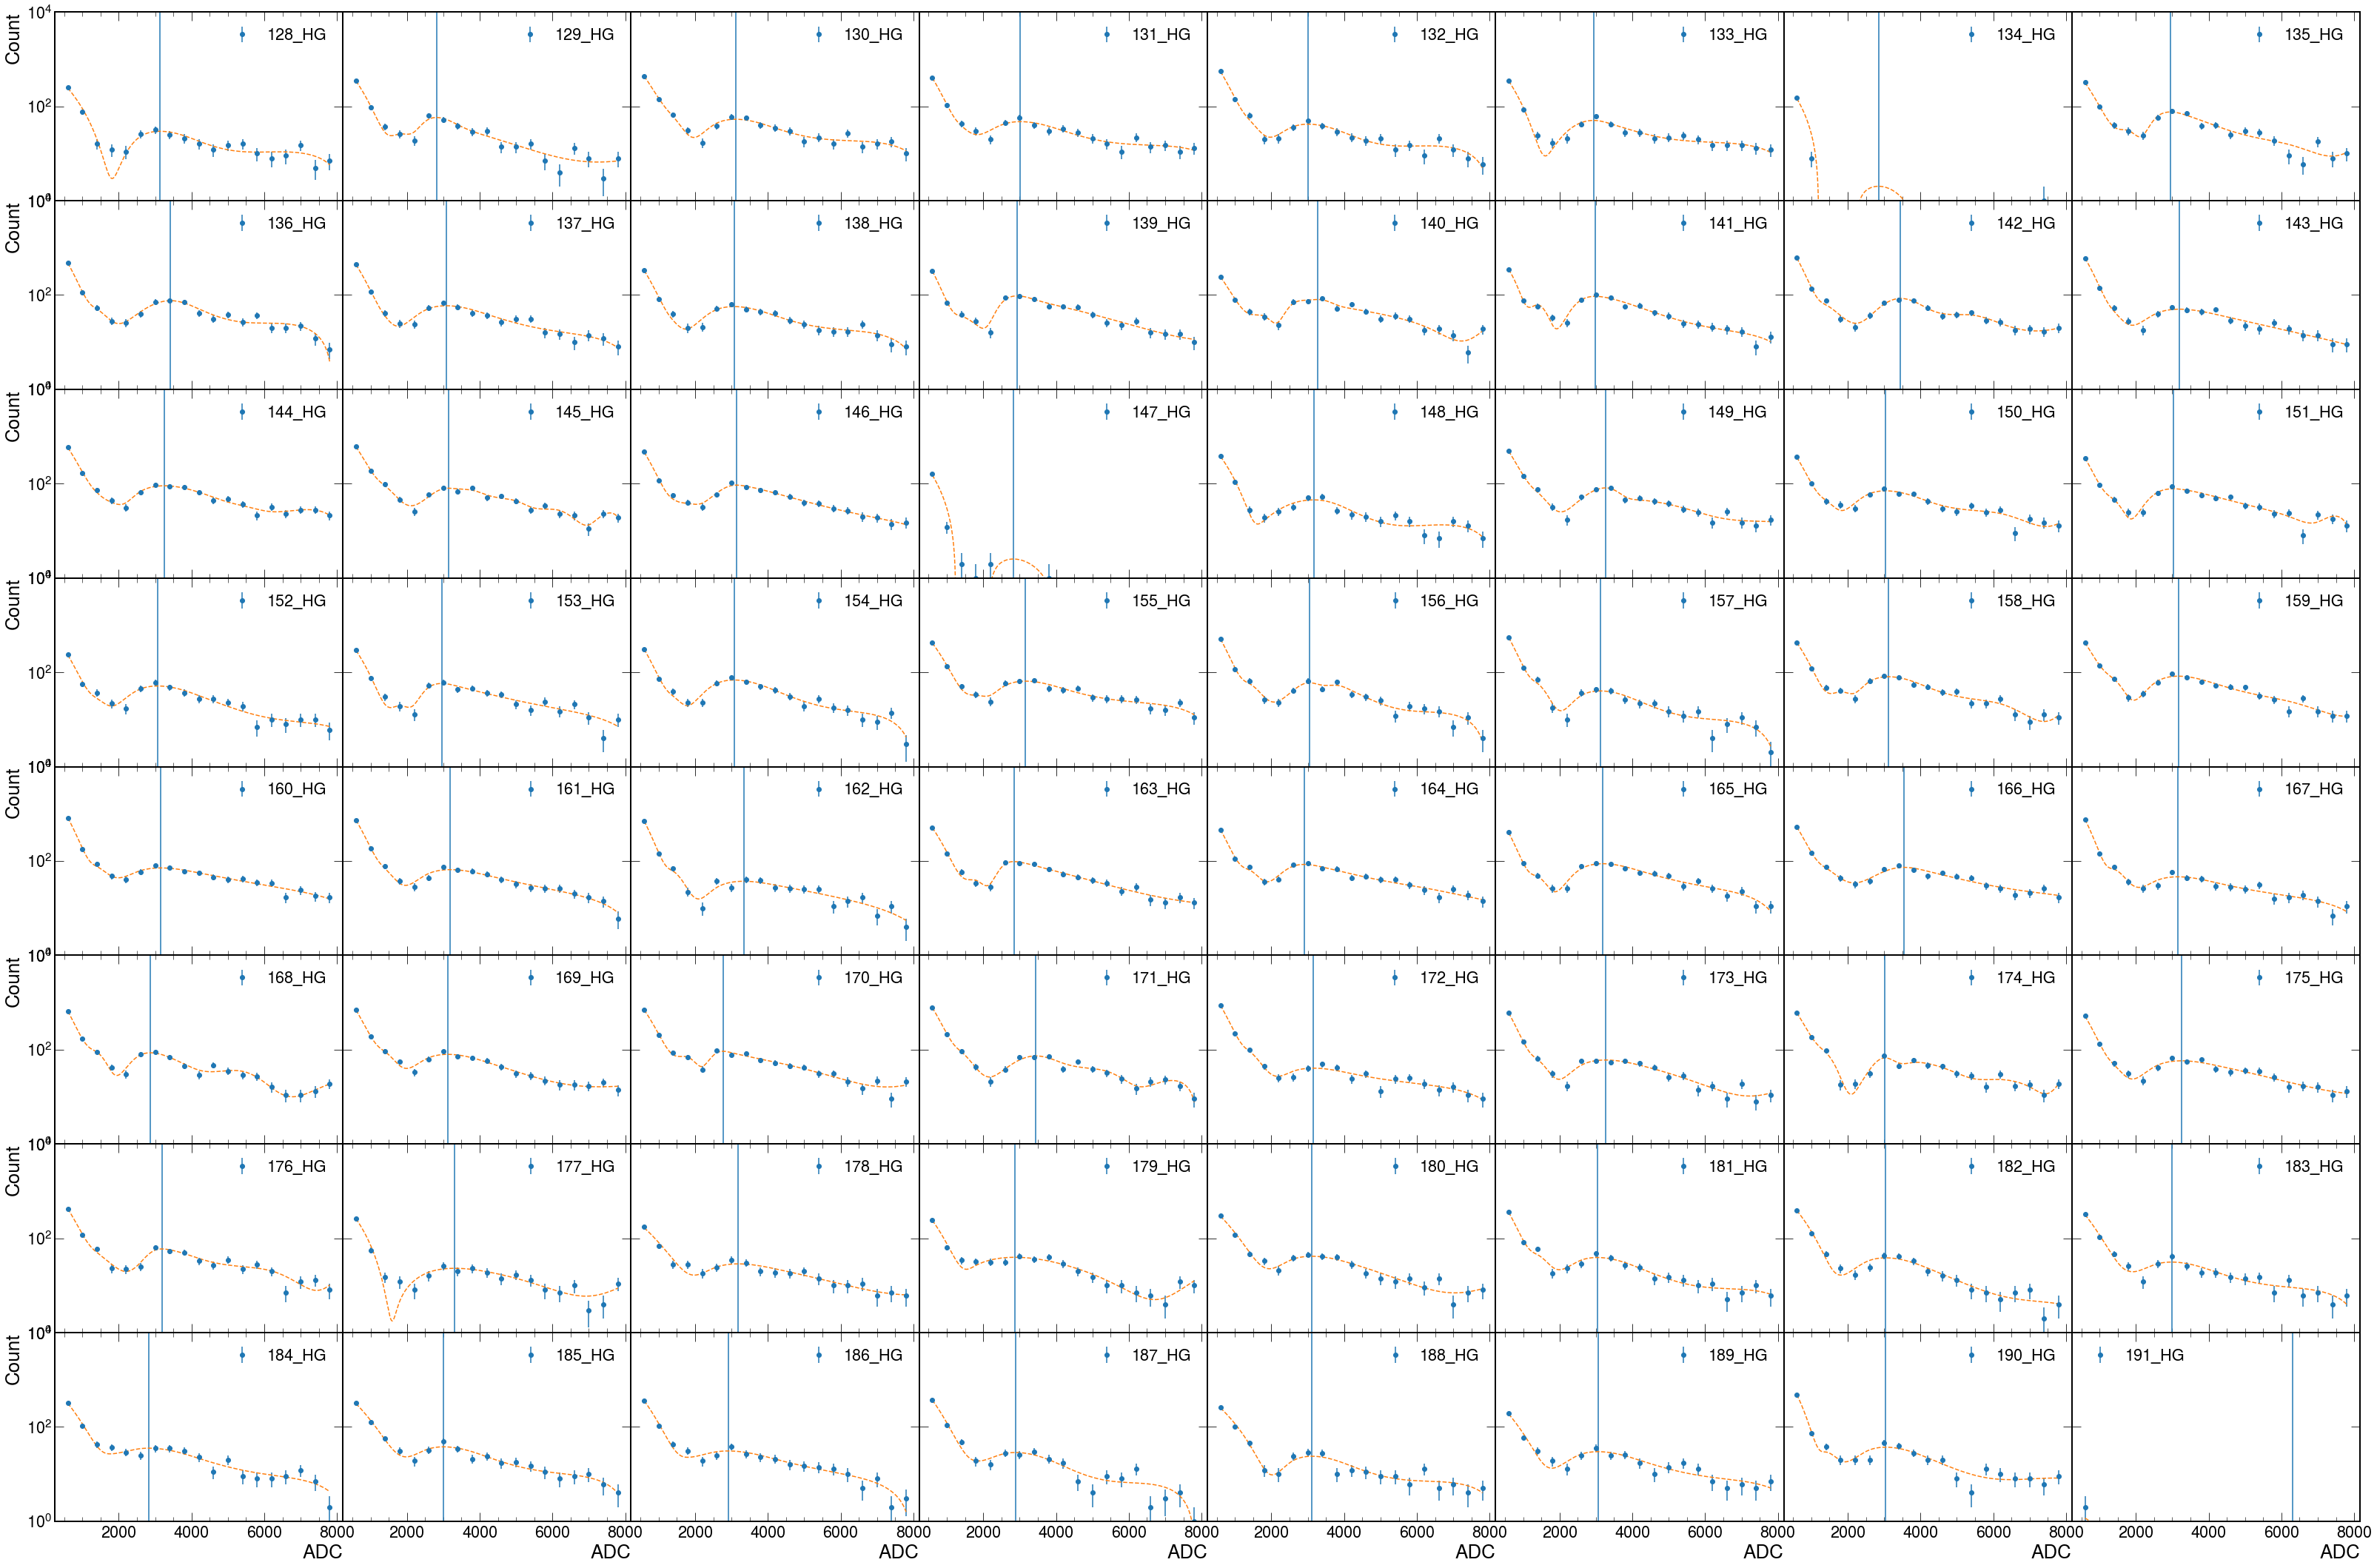

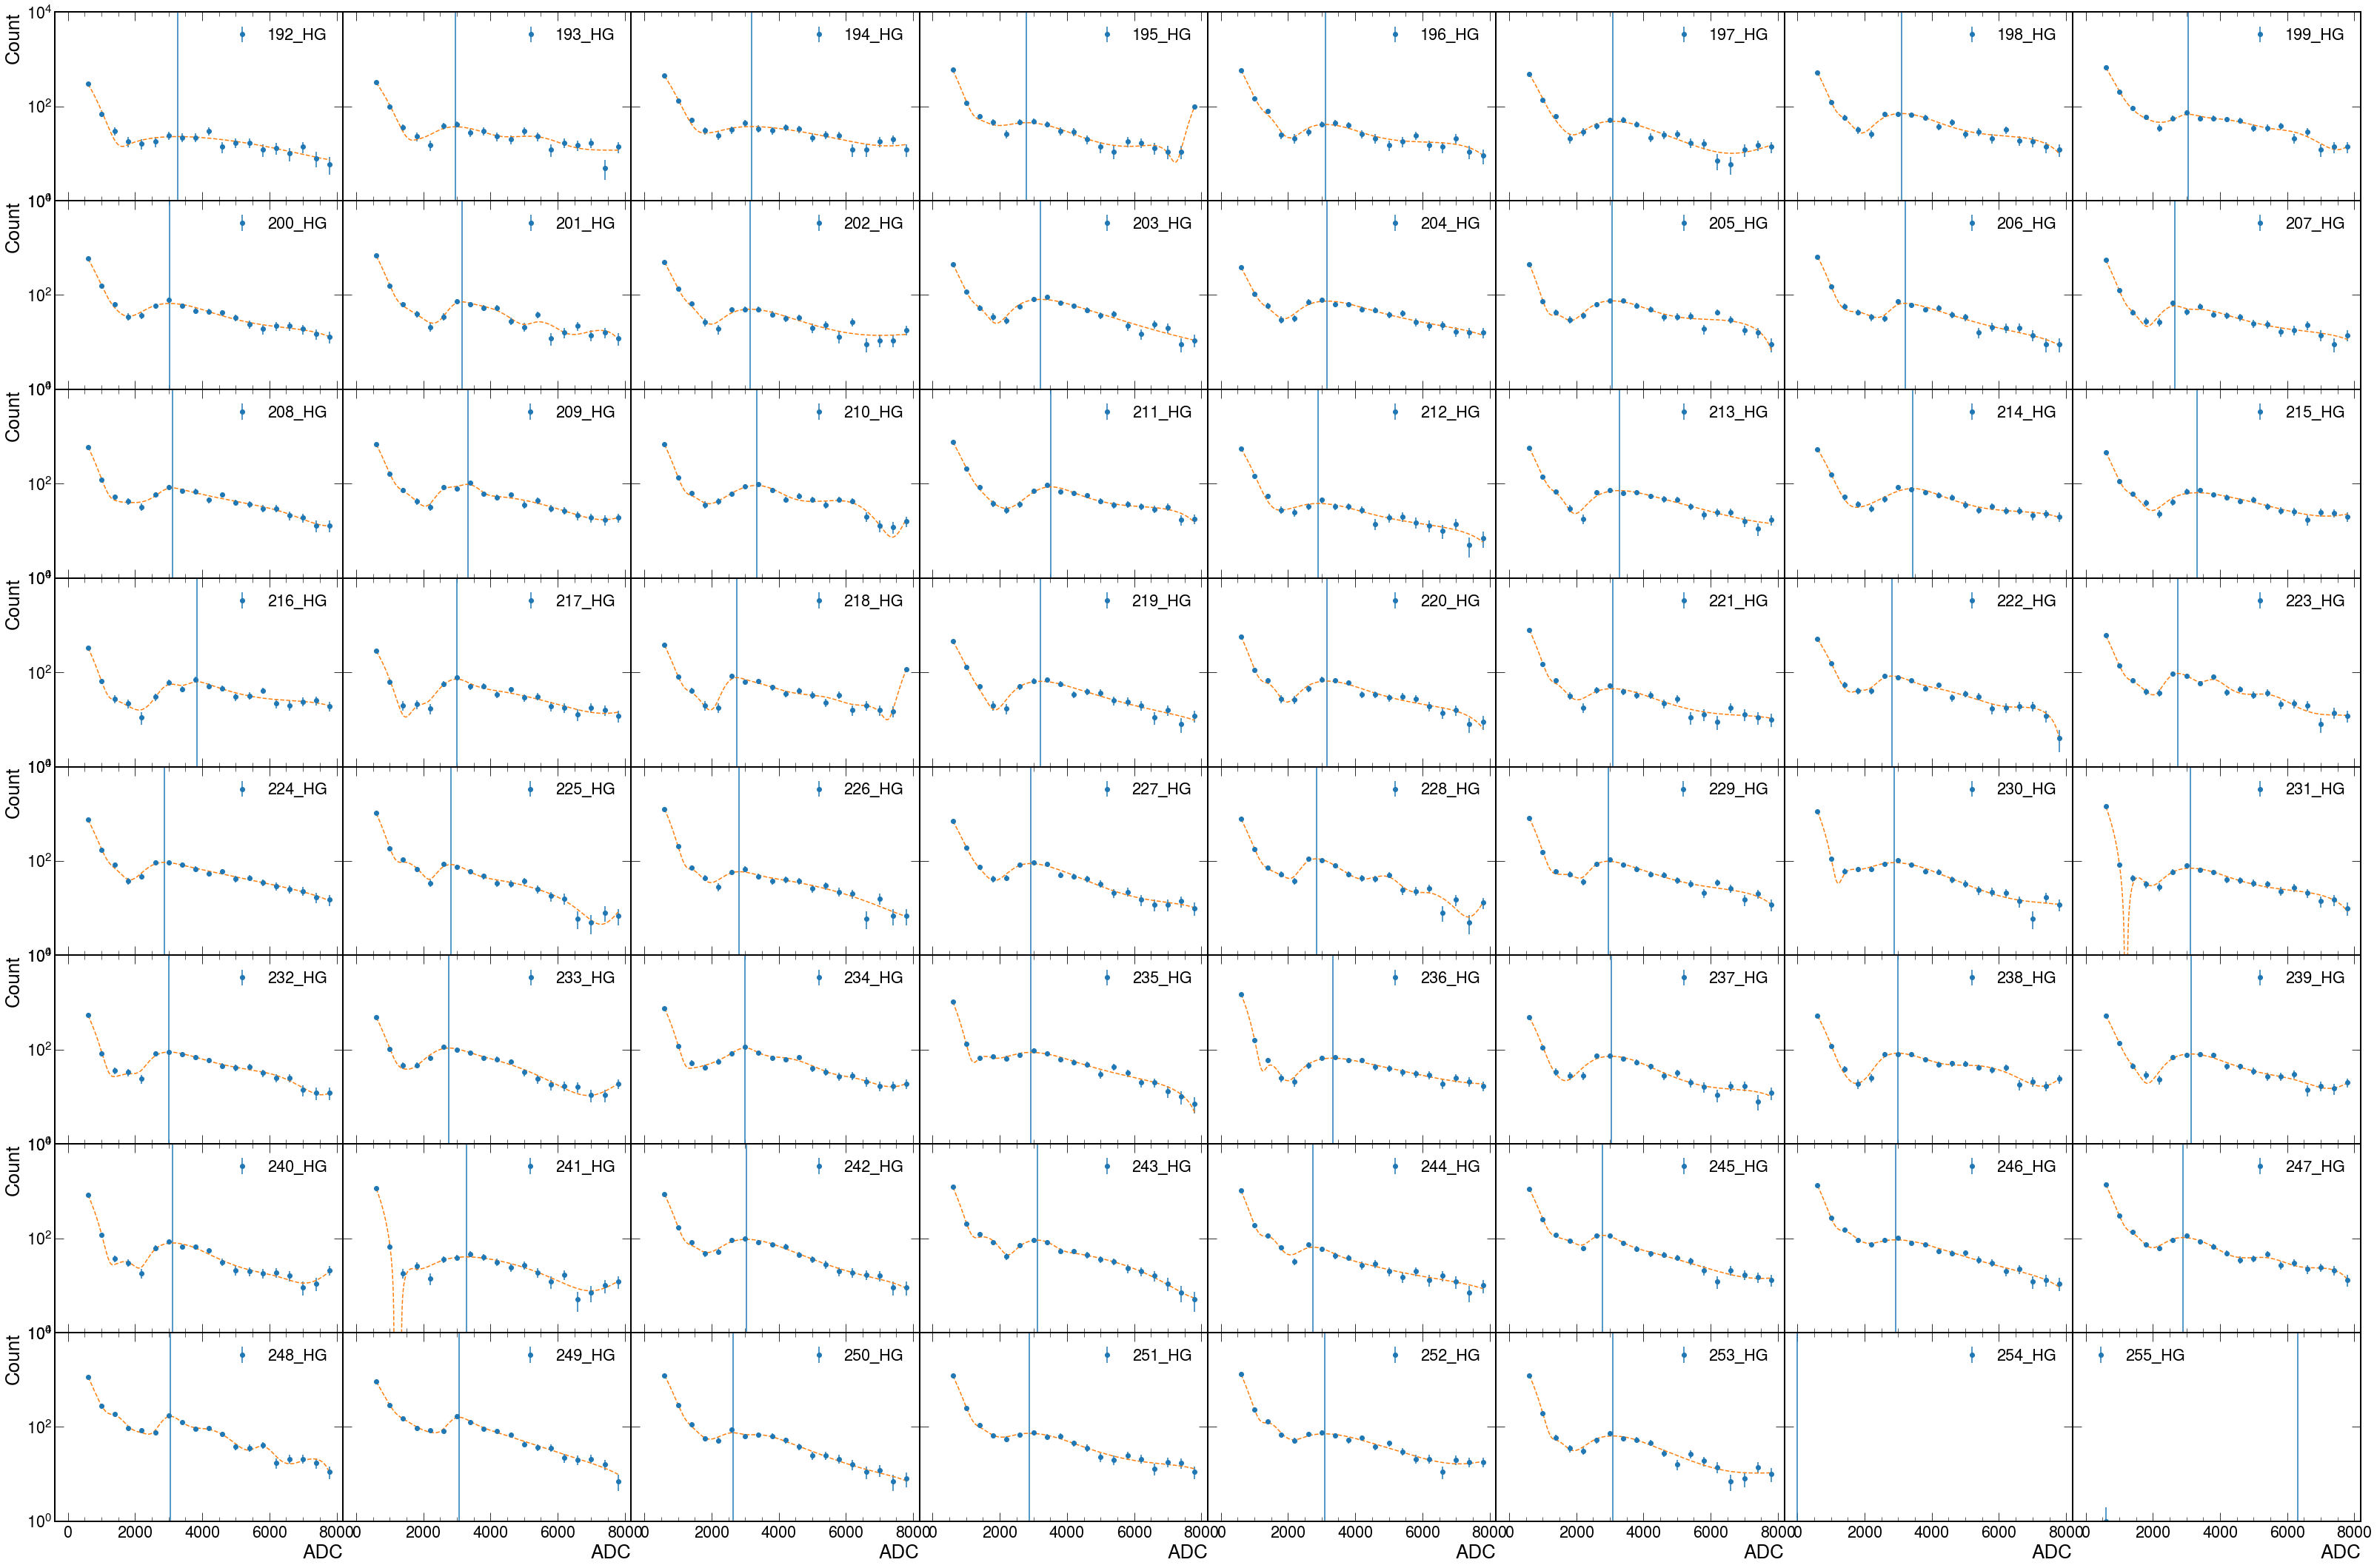

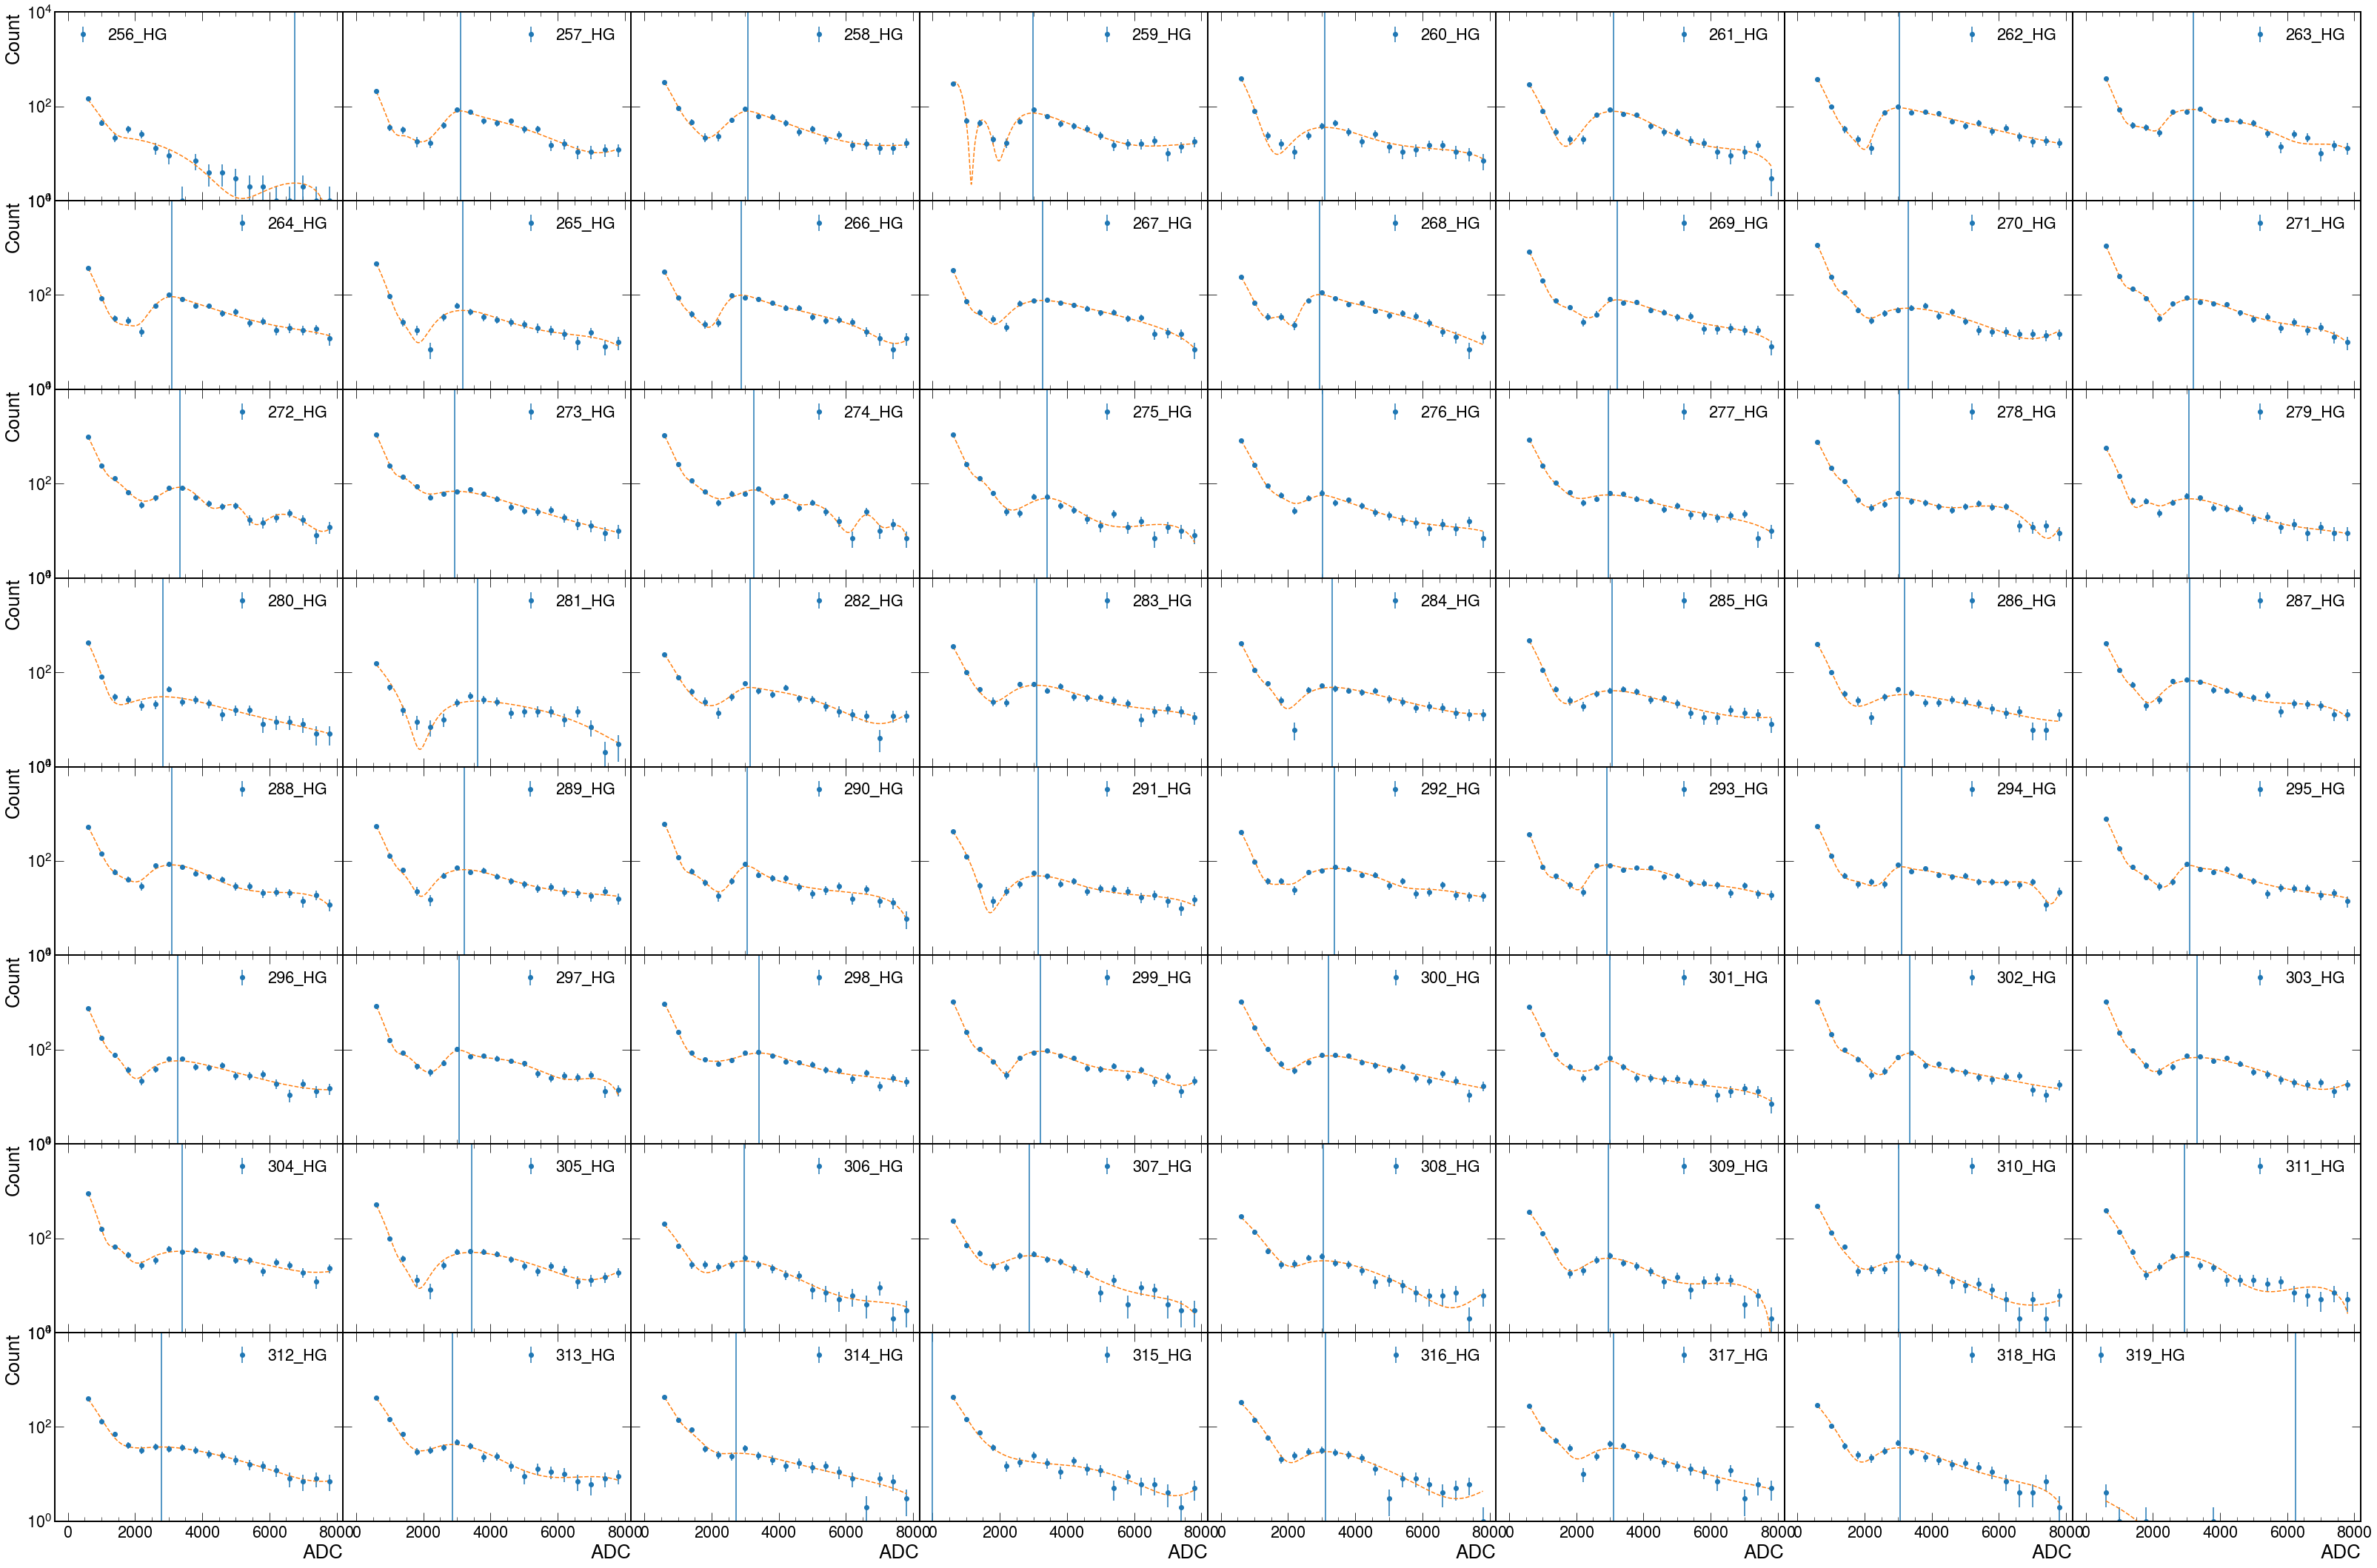

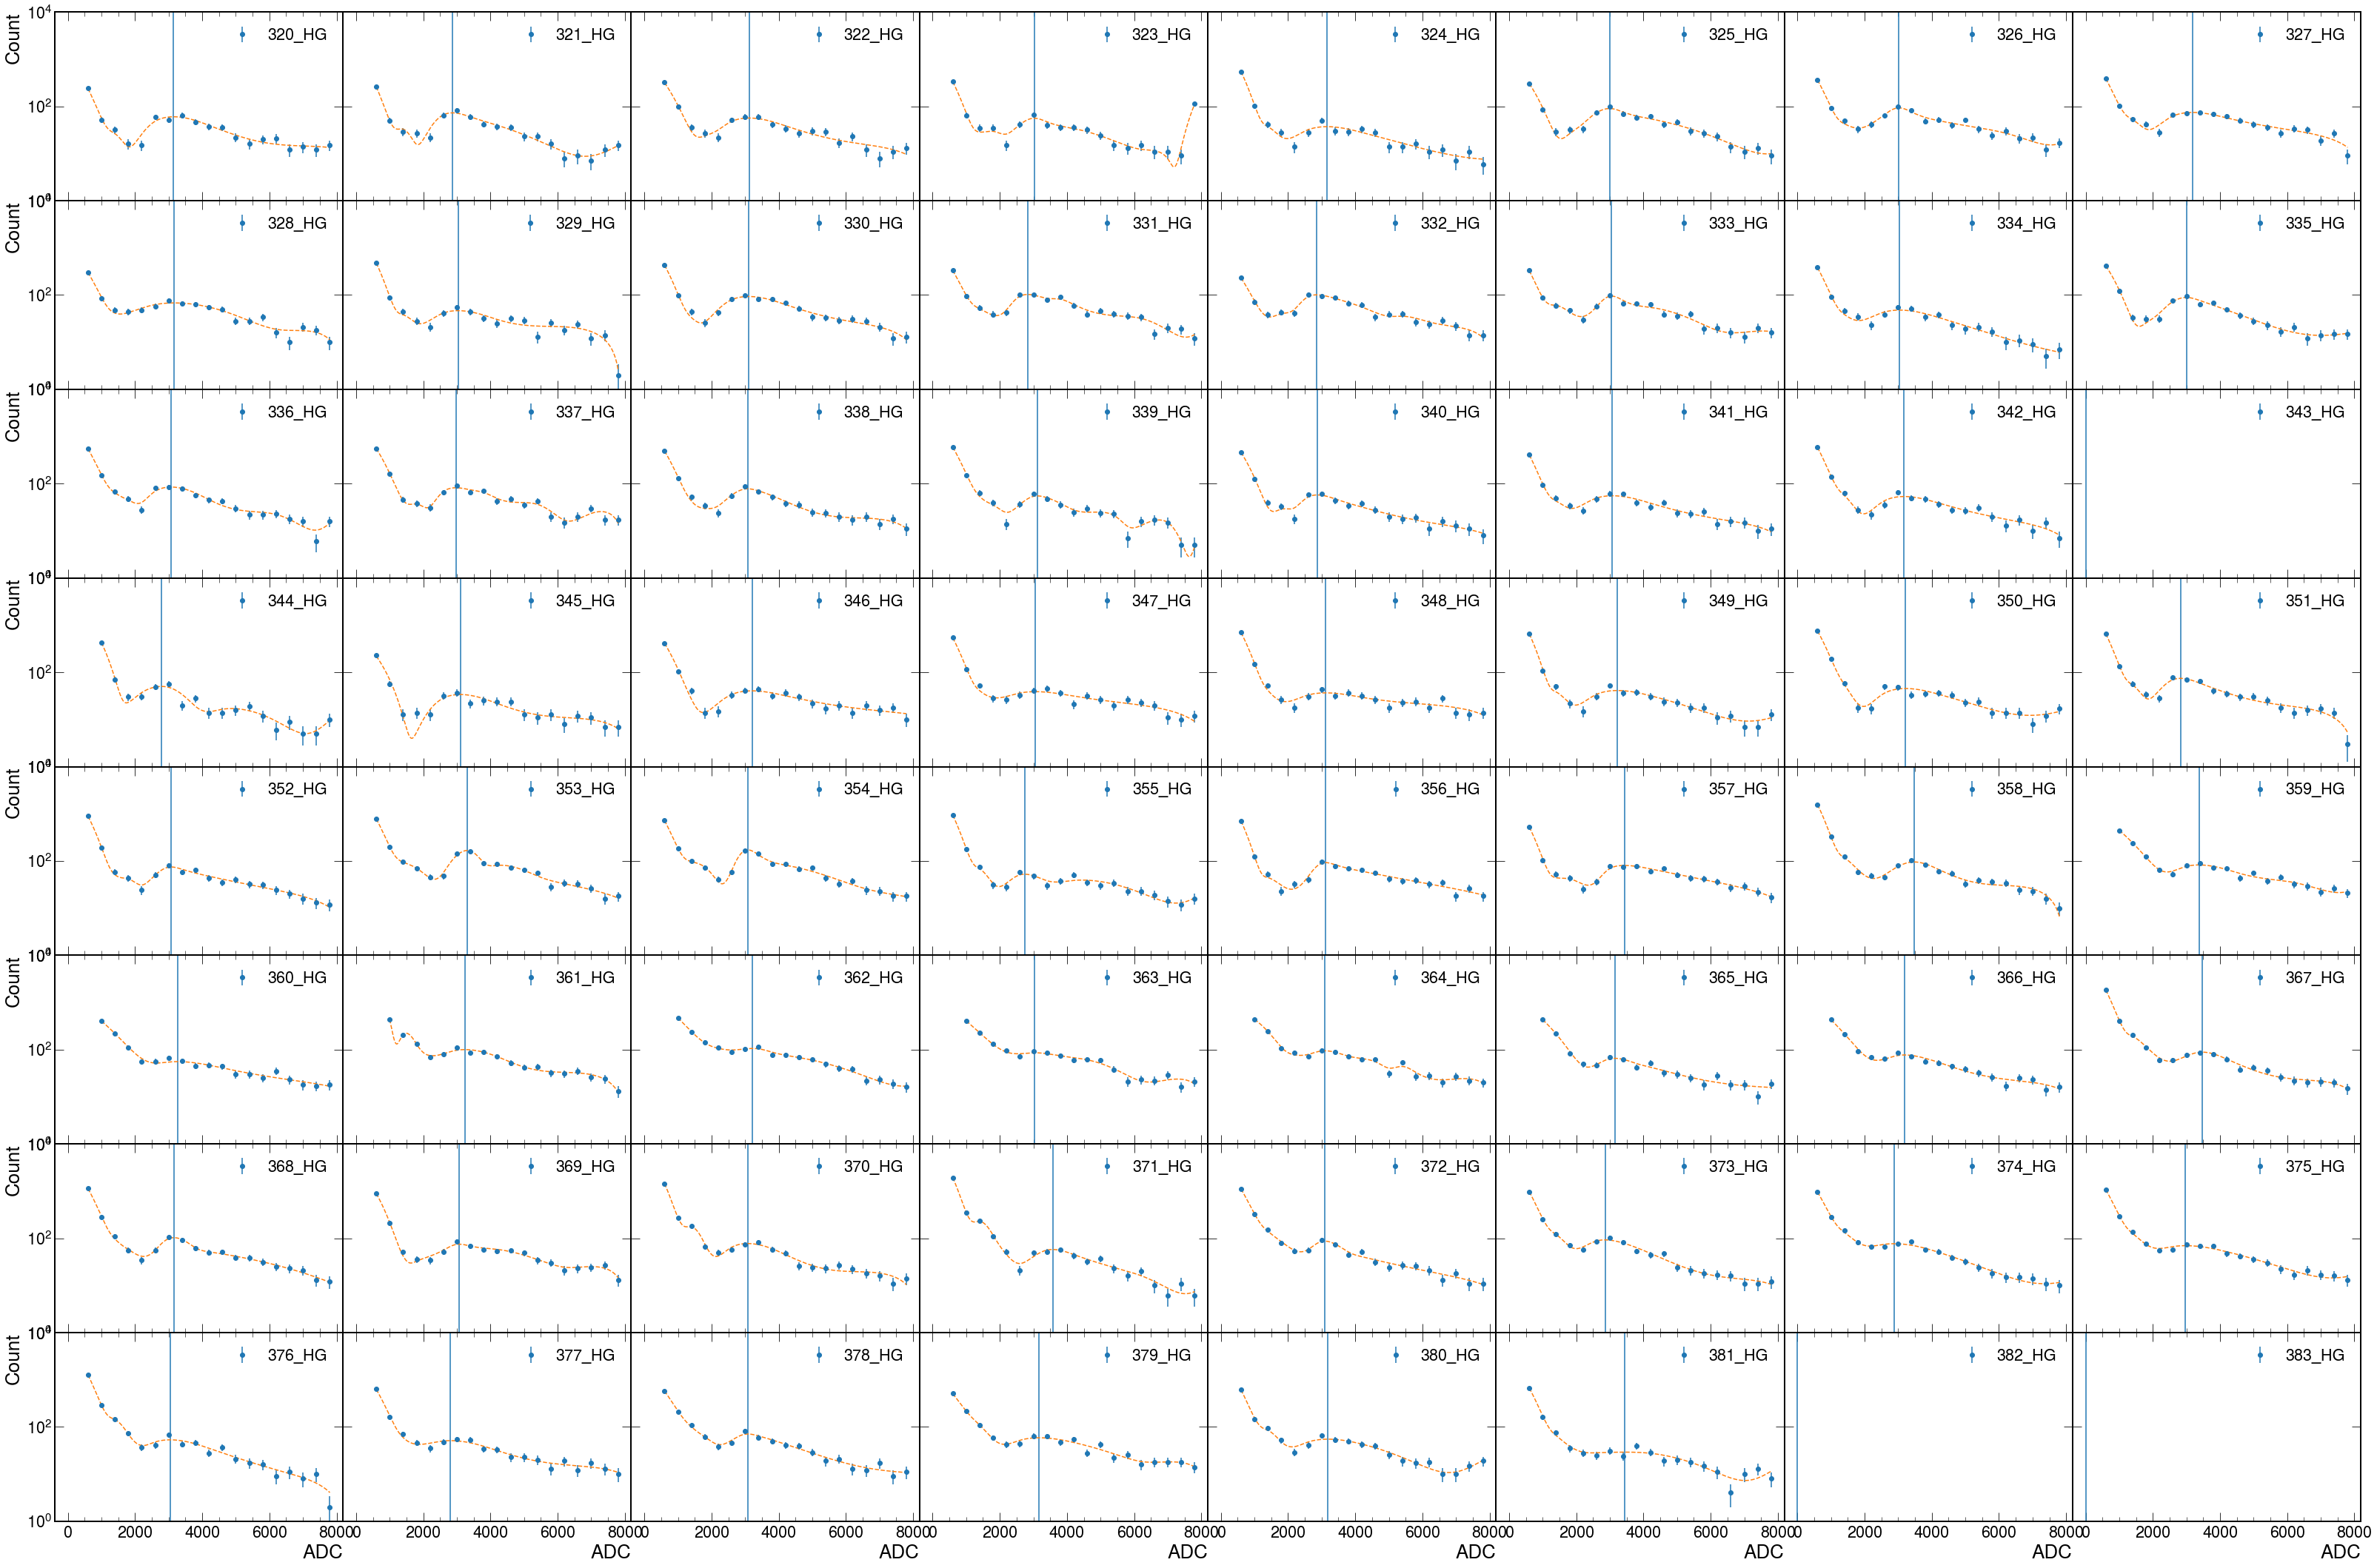

In [6]:
MIPs = []
configure_plotting()
for unit in range(6):
    analyze_caen_unit(din, unit, MIPs)

In [9]:
new_MIPs = np.array(MIPs) - np.array(HGPedMean)

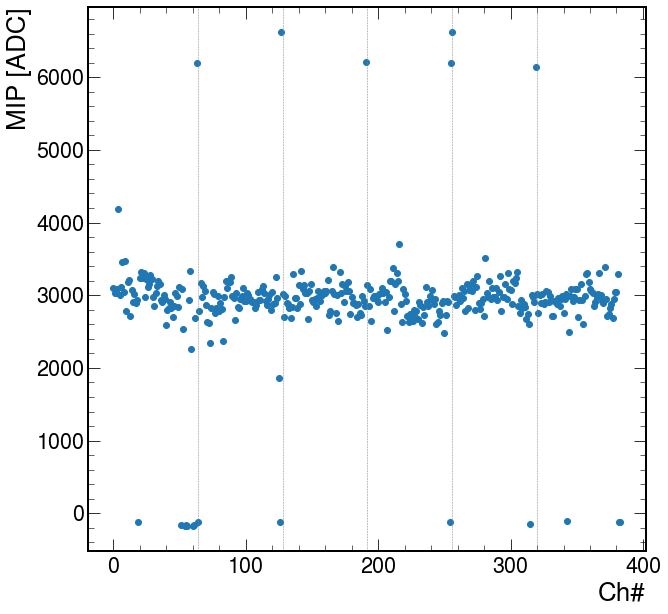

In [10]:
configure_plotting()
plt.scatter(x=range(64*6), y=new_MIPs)
plt.xlabel("Ch#")
plt.ylabel("MIP [ADC]")

for x in range(64, 64*6, 64):
        plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)

Text(0, 1, 'Counts')

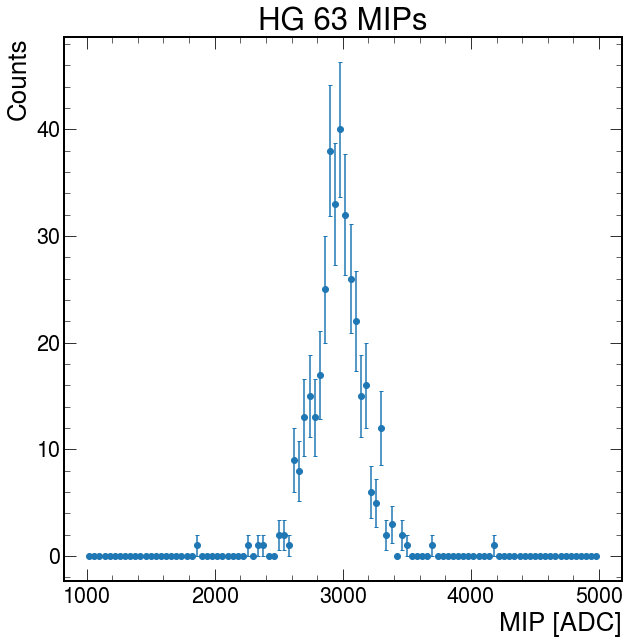

In [11]:
configure_plotting()
filtered = np.array(new_MIPs)[np.array(new_MIPs) > 0]
counts, bin_edges = np.histogram(filtered, bins=100, range=(1000, 5000))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
y_errors = np.sqrt(counts)
plt.errorbar(bin_centers, counts, yerr=y_errors, fmt='o', capsize=2)
plt.title("HG 63 MIPs")
plt.xlabel("MIP [ADC]")
plt.ylabel("Counts")

In [12]:
in_range_mask = (new_MIPs >= 2500) & (new_MIPs <= 3500)
in_range_mean = new_MIPs[in_range_mask].mean()
print(in_range_mean)

# Replace values outside the range with the mean
clean_MIPs = np.where(in_range_mask, new_MIPs, in_range_mean)

2964.236139634199


In [13]:
indexes_to_zero = [
    63, 64, 112, 113, 125, 126, 127,
    134, 147, 191, 254, 255, 319,
    343, 382, 383
]

for idx in indexes_to_zero:
    clean_MIPs[idx] = 0

(0.0, 4000.0)

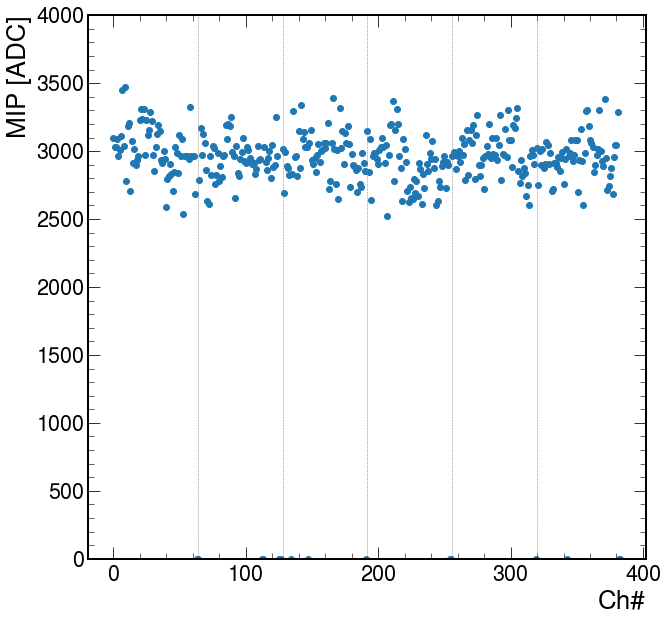

In [14]:
configure_plotting()
plt.scatter(x=range(64*6), y=clean_MIPs)
plt.xlabel("Ch#")
plt.ylabel("MIP [ADC]")

for x in range(64, 64*6, 64):
        plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)
        
plt.ylim(0,4000)

In [15]:
with open('../../genIII_data/JLab/Cosmic/Cosmic_MIPs.pkl', 'wb') as f:
    pickle.dump(clean_MIPs, f)

In [58]:
allChHG = []

for i in range(25):
    for j in range(len(din[f'{i}_HG'])):
        allChHG.append(din[f'{i}_HG'][j] - HGPedMean[i])
        

2732.5725725725724


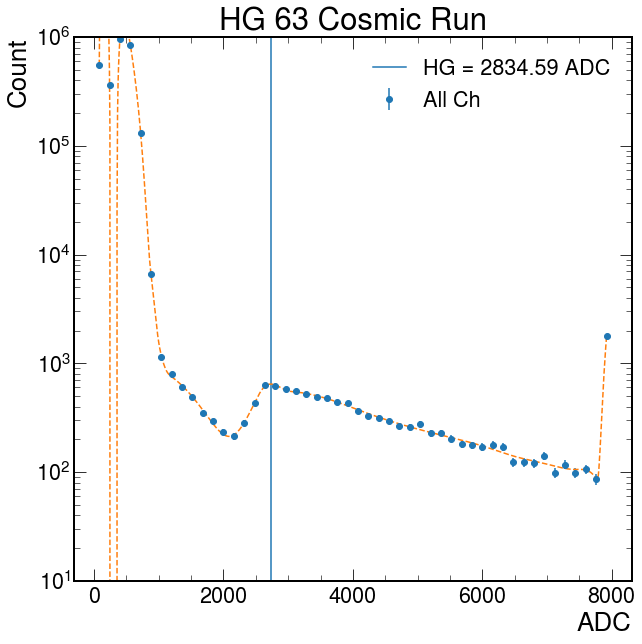

In [59]:
configure_plotting()
data = np.array(allChHG)
counts, bin_edges = np.histogram(data, bins=50, range=[0, 8000])
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
errors = np.sqrt(counts)

plt.errorbar(bin_centers, counts, yerr=errors, fmt='o', label="All Ch")

# Smooth histogram with spline
spline = UnivariateSpline(bin_centers, counts, s=10000, k=3)
interp_x = np.linspace(bin_centers[0], bin_centers[-1], 1000)
interp_y = spline(interp_x)

# Find peaks
peaks, _ = find_peaks(interp_y, height=0)
peak_positions = interp_x[peaks]
mip_peak = 0
for pos in peak_positions:
    if 1000 <= pos <= 6000:
        mip_peak = pos
        break

plt.axvline(x=mip_peak, label="HG = 2834.59 ADC")
plt.plot(interp_x, interp_y, linestyle="--")
plt.ylim(10,1000000)
plt.xlabel("ADC")
plt.ylabel("Count")
plt.title("HG 63 Cosmic Run")
plt.legend()
plt.yscale('log')
print(mip_peak)

In [13]:
MIPs = []

for i in range(64*6):
    MIPs.append(2834.5945945945946)
    
with open('../../genIII_data/JLab/Cosmic/Avg-MIPs.pkl', 'wb') as f:
    pickle.dump(MIPs, f)